## 1. Sep Up

### 1.1 Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### 1.2 Install the Hugging Face Library

In [4]:
!pip install -q -U watermark

In [5]:
!pip install transformers==3

     |████████████████████████████████| 757kB 10.8MB/s 
     |████████████████████████████████| 890kB 23.1MB/s 
     |████████████████████████████████| 1.2MB 45.4MB/s 
     |████████████████████████████████| 3.0MB 43.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=347f73c898d91099a8af5ee93e2de53367391011a7b266ee21dfd7211bb91e97
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
#!pip install -qq transformers

In [6]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.8.0+cu101
transformers: 3.0.0



In [ ]:
#device(type='cuda',index=0)

In [7]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

### 1.3 Load Data

In [8]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
#import io
#df = pd.read_csv(io.StringIO(uploaded['clean_wine_dataset.csv'].decode('utf-8')))

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
path = "/content/drive/MyDrive/clean_wine_dataset.csv"
df = pd.read_csv(path)

In [ ]:
#df = pd.read_csv('/content/clean_wine_dataset.csv')

In [12]:
df.head()

,description,designation,points,price,province,variety,winery
0,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Sauvignon Blanc,Macauley
1,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Pinot Noir,Ponzi
2,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Provence red blend,Domaine de la Bégude
3,"Deep, dense and pure from the opening bell, th...",Numanthia,95,73.0,Northern Spain,Tinta de Toro,Numanthia
4,Slightly gritty black-fruit aromas include a s...,San Román,95,65.0,Northern Spain,Tinta de Toro,Maurodos


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


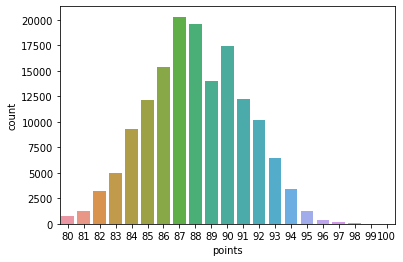

In [13]:
sns.countplot(df.points)

In [14]:
df.points.describe()

count    152261.000000
mean         88.061651
std           3.061179
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

In [15]:
def sentiment_label(x):
  if x <= 83:
    return 'negative'
  elif x>= 90:
    return 'positive'
  else:
    return 'neutral'

def sentiment_score(x):
  if x <= 83:
    return 0
  elif x>= 90:
    return 1
  else:
    return 2

In [16]:
#df['sentiment_label'] = df.points.apply(lambda x: sentiment_label(x))
df['sentiment_score'] = df.points.apply(lambda x: sentiment_score(x))

In [17]:
df.drop(['points','price'],axis=1, inplace=True)

In [18]:
df.isnull().sum()

description            0
designation        45740
province               0
variety                0
winery                 0
sentiment_score        0
dtype: int64

In [19]:
df.designation.fillna('na',inplace=True)

In [20]:
df['words'] = df['description']+' '+df['designation']+' It is from '+df['province']+' The variety is '+df['variety']+' The winery is '+df['winery']

In [21]:
df = df.loc[:,['words','sentiment_score']]
df.head()

,words,sentiment_score
0,Mac Watson honors the memory of a wine once ma...,1
1,"This spent 20 months in 30% new French oak, an...",1
2,"This is the top wine from La Bégude, named aft...",1
3,"Deep, dense and pure from the opening bell, th...",1
4,Slightly gritty black-fruit aromas include a s...,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


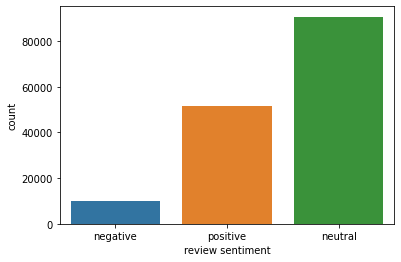

In [22]:
class_names = ['negative', 'positive', 'neutral']
ax = sns.countplot(df.sentiment_score)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [23]:
sentences = df.words.values
labels = df.sentiment_score.values

## 2. Data Preprocessing for BERT Model

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [25]:
sample_txt = sentences[0]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar. Special Selected Late Harvest It is from California The variety is Sauvignon Blanc The winery is Macauley
   Tokens: ['Mac', 'Watson', 'honors', 'the', 'memory', 'of', 'a', 'wine', 'once', 'made', 'by', 'his', 'mother', 'in', 'this', 'tremendous', '##ly', 'delicious', ',', 'balanced', 'and', 'complex', 'b', '##ot', '##ry', '##tised', 'white', '.', 'Dark', 'gold', 'in', 'color', ',', 'it', 'layers', 'toast', '##ed', 'haze', '##ln', '##ut', ',', 'p', '##ear', 'com', '##pot', '##e', 'and', 'orange', 'p', '##eel', 'flavor', '##s', ',', 're', '##vel', '##ing', 'in', 'the', 'su', '##cc', '##ule', '##nce', 'of', 'its', '122', 'g', '/', 'L', 'of', 'residual', 'sugar', '.', 'Special', 'Selected', 'Late', 'Ha

In [26]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=100,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


dict_keys(['input_ids', 'attention_mask'])

In [27]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

100


tensor([  101,  6603,  7422,  8357,  1103,  2962,  1104,   170,  4077,  1517,
         1189,  1118,  1117,  1534,  1107,  1142, 15194,  1193, 13108,   117,
        12591,  1105,  2703,   171,  3329,  1616, 25048,  1653,   119,  4753,
         2284,  1107,  2942,   117,  1122,  8798, 17458,  1174, 19691, 21615,
         3818,   117,   185, 19386,  3254, 11439,  1162,  1105,  5925,   185,
        19032, 16852,  1116,   117,  1231, 12559,  1158,  1107,  1103, 28117,
        19515,  8722,  3633,  1104,  1157, 13381,   176,   120,   149,  1104,
        25399,  6656,   119,  3139, 17018,  6372, 23119,  1135,  1110,  1121,
         1756,  1109,  2783,  1110, 17784,  1358, 24724, 24687,  1109,  4077,
         1616,  1110, 17982,  1926,   102,     0,     0,     0,     0,     0])

In [28]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

100


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0]])

In [29]:
token_lens = []

for txt in df.words:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


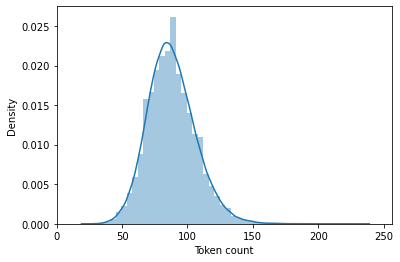

In [30]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [31]:
MAX_LEN = 200

In [32]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [33]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=2021)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=2021)

In [34]:
df_train.shape, df_val.shape, df_test.shape

((137034, 2), (7613, 2), (7614, 2))

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.words.to_numpy(),
    targets=df.sentiment_score.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [36]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [37]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [38]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 200])
torch.Size([32, 200])
torch.Size([32])


## 3. Sentiment Classification with BERT and Hugging Face

In [39]:
bert_model = BertModel.from_pretrained('bert-base-cased')

In [40]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [41]:
last_hidden_state.shape

torch.Size([1, 100, 768])

In [42]:
pooled_output.shape

torch.Size([1, 768])

In [43]:
bert_model.config.hidden_size

768

In [44]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [45]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [46]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 200])
torch.Size([32, 200])


In [47]:
data['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [48]:
input_ids.dtype

torch.int64

In [49]:
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5134, 0.2949, 0.1917],
        [0.4817, 0.1144, 0.4040],
        [0.3298, 0.1427, 0.5275],
        [0.5904, 0.1560, 0.2535],
        [0.5291, 0.1816, 0.2894],
        [0.5816, 0.1187, 0.2997],
        [0.4094, 0.1137, 0.4769],
        [0.5736, 0.2288, 0.1976],
        [0.4409, 0.1561, 0.4031],
        [0.6180, 0.1849, 0.1971],
        [0.4975, 0.2720, 0.2305],
        [0.3759, 0.2400, 0.3840],
        [0.4215, 0.2677, 0.3108],
        [0.5424, 0.2536, 0.2039],
        [0.5418, 0.1739, 0.2842],
        [0.4721, 0.1940, 0.3339],
        [0.5397, 0.1607, 0.2997],
        [0.4341, 0.1863, 0.3796],
        [0.4582, 0.1771, 0.3647],
        [0.4682, 0.1643, 0.3674],
        [0.5235, 0.1794, 0.2971],
        [0.3658, 0.1953, 0.4389],
        [0.4836, 0.1892, 0.3271],
        [0.3741, 0.3040, 0.3219],
        [0.3707, 0.1929, 0.4364],
        [0.3818, 0.2294, 0.3888],
        [0.5015, 0.1942, 0.3043],
        [0.3505, 0.1407, 0.5088],
        [0.4643, 0.2301, 0.3056],
        [0.483

### 3.1 Training

In [50]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [51]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [53]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.46120961461352766 accuracy 0.7978968723090619
Val   loss 0.3981599522864117 accuracy 0.8262183107841848

Epoch 2/3
----------
Train loss 0.36256697463767984 accuracy 0.8448925084285651
Val   loss 0.38207694766025585 accuracy 0.8334427952187048

Epoch 3/3
----------
Train loss 0.3016135908642398 accuracy 0.8740458572325116
Val   loss 0.4092164462228783 accuracy 0.8295021673453303

CPU times: user 1h 18min 17s, sys: 53min 55s, total: 2h 12min 12s
Wall time: 2h 12min 16s


In [54]:
model.save(args["model"], save_format="h5")

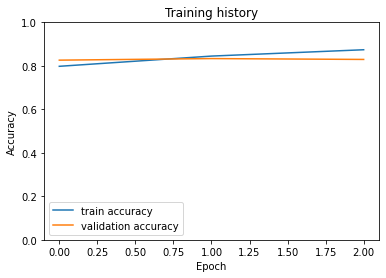

In [55]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### 3.2 Evaluation

In [56]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8389808247964277

In [57]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = nn.functional.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [58]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [59]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.74      0.64      0.68       484
    positive       0.82      0.83      0.82      2664
     neutral       0.86      0.87      0.86      4466

    accuracy                           0.84      7614
   macro avg       0.81      0.78      0.79      7614
weighted avg       0.84      0.84      0.84      7614



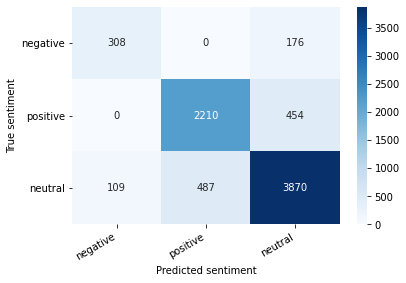

In [60]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [61]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [62]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Angimbé (a 70-30 blend of Insolia and Chardonnay from Sicily) delivers
aromas of acacia, peach blossom and powdery peppermint. The wine has a
sweet, saccharine-like quality and is very perfumed and sticky in the
mouth. Angimbé It is from Sicily & Sardinia The variety is White Blend
The winery is Cusumano

True sentiment: neutral


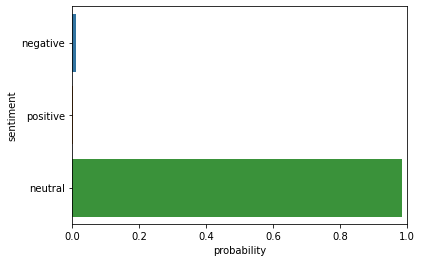

In [63]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

# 4. Sentiment Analysis with Random Forest and Gradient Boosting

### 4.1 Words Format

In [64]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [65]:
from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') 

In [66]:
import re
# cleaning punctuations from the sentence
sentence = "I'd like to have some coffee today!"
sentence = re.sub(r'[\'|"|#]', r'', sentence) # remove these punctuation
sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
sentence

'Id like to have some coffee today '

In [67]:
def cleanup(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # lower case
    sentence = re.sub(r'[?|!|.|,|)|(|\|/]',r' ',sentence) # replace these punctuation with space
    tokens = sentence.split()
    out = []
    for t in tokens:
        out.append(snow.stem(t))
    out = " ".join(out)
    out = re.sub(r'[\'|"|#]', r'', out) # remove these punctuation
    return out 

In [68]:
print(cleanup("how are you today?"))

how are you today


In [69]:
df1 = df.copy()
df1.head()

,words,sentiment_score
0,Mac Watson honors the memory of a wine once ma...,1
1,"This spent 20 months in 30% new French oak, an...",1
2,"This is the top wine from La Bégude, named aft...",1
3,"Deep, dense and pure from the opening bell, th...",1
4,Slightly gritty black-fruit aromas include a s...,1


In [70]:
df1['clean_words'] = df1['words'].apply(cleanup)

In [71]:
df1.head()

,words,sentiment_score,clean_words
0,Mac Watson honors the memory of a wine once ma...,1,mac watson honor the memori of a wine onc made...
1,"This spent 20 months in 30% new French oak, an...",1,this spent 20 month in 30% new french oak and ...
2,"This is the top wine from La Bégude, named aft...",1,this is the top wine from la bégude name after...
3,"Deep, dense and pure from the opening bell, th...",1,deep dens and pure from the open bell this tor...
4,Slightly gritty black-fruit aromas include a s...,1,slight gritti black-fruit aroma includ a sweet...


### 4.2 Cloud Words

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=None,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

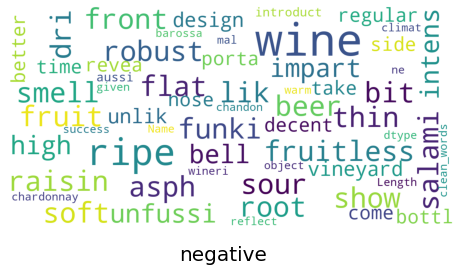

In [73]:
show_wordcloud(df1.clean_words.loc[df1.sentiment_score == 0], title = "negative")

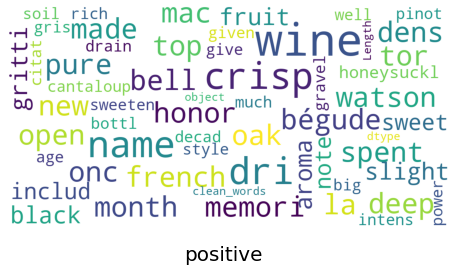

In [74]:
show_wordcloud(df1.clean_words.loc[df1.sentiment_score == 1], title = "positive")

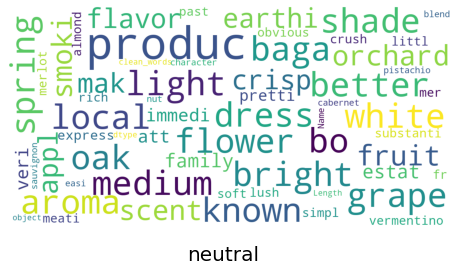

In [75]:
show_wordcloud(df1.clean_words.loc[df1.sentiment_score == 2], title = "neutral")

### 4.3 Split Training & Testing Dataset

In [76]:
df1.drop(['words'], inplace=True, axis=1)

In [77]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df1, test_size=0.2, random_state = 1)
print("%d items in training data, %d in test data" % (len(train), len(test)))

121808 items in training data, 30453 in test data


### 4.4 Convert Words to Vector

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [79]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df = 5)
tfidf_vectors_train = tfidf.fit_transform(train['clean_words'].values)
tfidf_vectors_test = tfidf.transform(test['clean_words'].values)

In [80]:
y_train = train["sentiment_score"]
y_test = test["sentiment_score"]

### 4.5 Train and Test the Model

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics

#### 4.5.1 Model - Random Forest

In [82]:
rf = RandomForestClassifier()
rf.fit(tfidf_vectors_train,y_train.values)
rf_tfidf_prediction = rf.predict(tfidf_vectors_test)

In [98]:
rf_accuracy = metrics.accuracy_score(y_test, rf_tfidf_prediction)
print('Random Forest: {:.3f}'.format(rf_accuracy))

Random Forest: 0.742


In [84]:
print(classification_report(y_test,rf_tfidf_prediction))

              precision    recall  f1-score   support

           0       0.82      0.16      0.27      1999
           1       0.79      0.56      0.65     10317
           2       0.73      0.91      0.81     18137

    accuracy                           0.74     30453
   macro avg       0.78      0.54      0.58     30453
weighted avg       0.75      0.74      0.72     30453



#### 4.5.2 Model - Gradient Boosting

In [85]:
boosting = GradientBoostingClassifier()
boosting.fit(tfidf_vectors_train,y_train.values)
boosting_tfidf_prediction = boosting.predict(tfidf_vectors_test)

In [99]:
boosting_accuracy = metrics.accuracy_score(y_test, boosting_tfidf_prediction)
print('Gradient Boosting: {:.3f}'.format(boosting_accuracy))

Gradient Boosting: 0.755


In [87]:
print(classification_report(y_test,boosting_tfidf_prediction))

              precision    recall  f1-score   support

           0       0.79      0.27      0.40      1999
           1       0.79      0.59      0.67     10317
           2       0.74      0.90      0.81     18137

    accuracy                           0.75     30453
   macro avg       0.77      0.59      0.63     30453
weighted avg       0.76      0.75      0.74     30453



#### 4.5.3 Model - Voting Classifier

In [88]:
rf = RandomForestClassifier()
boosting = GradientBoostingClassifier()

classifiers = [('Random Forest', rf),
('Gradient Boosting', boosting)]

In [89]:
vc = VotingClassifier(estimators=classifiers)
vc.fit(tfidf_vectors_train,y_train.values)
voting_tfidf_pred = vc.predict(tfidf_vectors_test)

In [96]:
accuracy = metrics.accuracy_score(y_test, voting_tfidf_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))

Voting Classifier: 0.762


In [91]:
print(classification_report(y_test,voting_tfidf_pred))

              precision    recall  f1-score   support

           0       0.77      0.29      0.42      1999
           1       0.76      0.66      0.71     10317
           2       0.76      0.88      0.81     18137

    accuracy                           0.76     30453
   macro avg       0.76      0.61      0.65     30453
weighted avg       0.76      0.76      0.75     30453



## 5. Conclusion

#### Accuracy Soce
*   BERT Model: 0.84

*   Random Forest: 0.74

*   Gradient Boosting: 0.75

*   Voting Classifier: 0.76

In [102]:
Model = ['BERT','Random Forest','Gradient Boosting','Voting Classifer']
Accuracy = [0.84,0.742,0.755,0.762]

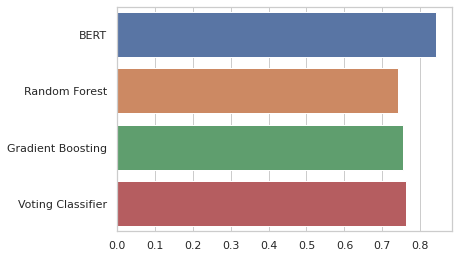

In [107]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=Model, x=Accuracy)